In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jul 12 22:45:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   35C    P2    32W / 250W |   6481MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |   6053MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mds_07July2020 import SimpleCNN5Layer_Ca_B as Model_B
from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 118)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 11.53 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 11.3 s
Constructing 160000 event dataset took 3.117 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.542 s
Constructing 9984 event dataset took 0.09399 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelE()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path, freeze_weights=True)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/4ca3505dac1e41edac25afec3b7a1384/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 4 weights
Of the 18.5 parameter layers to update in the current model, 4.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_E(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(25, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(9, eps=1e-05, momentu

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


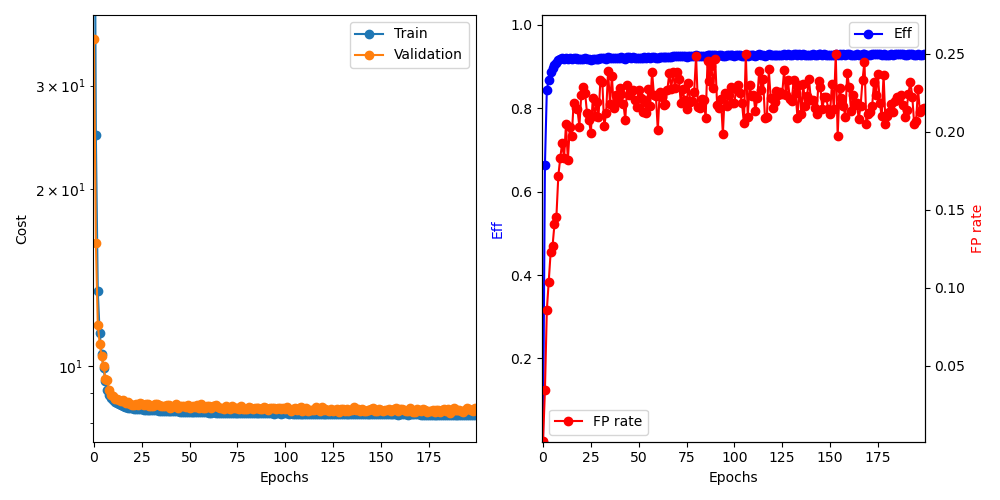

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [12]:
print('for model: ', model)   
run_name = 'SCNN to ACNN E'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate)) 
            
        # Redraw the figure
        fig.canvas.draw()  
        
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_E(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(25, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(9, eps=1e

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 118: train=140.61, val=35.9548, took 52.16 s
  Validation Found 19 of 54504, added 17 (eff 0.03%) (0.0017 FP/event)


Epoch 119: train=24.7604, val=16.2125, took 52.011 s
  Validation Found 36183 of 54504, added 343 (eff 66.39%) (0.0344 FP/event)


Epoch 120: train=13.4223, val=11.7583, took 51.878 s
  Validation Found 46047 of 54504, added 857 (eff 84.48%) (0.0858 FP/event)


Epoch 121: train=11.371, val=10.9022, took 51.424 s
  Validation Found 47313 of 54504, added 1037 (eff 86.81%) (0.104 FP/event)


Epoch 122: train=10.4767, val=10.4009, took 51.812 s
  Validation Found 48332 of 54504, added 1227 (eff 88.68%) (0.123 FP/event)


Epoch 123: train=9.91345, val=10.0046, took 55.17 s
  Validation Found 48801 of 54504, added 1269 (eff 89.54%) (0.127 FP/event)


Epoch 124: train=9.41599, val=9.51258, took 55.545 s
  Validation Found 49317 of 54504, added 1407 (eff 90.48%) (0.141 FP/event)


Epoch 125: train=9.08751, val=9.46447, took 56.038 s
  Validation Found 49522 of 54504, added 1454 (eff 90.86%) (0.146 FP/event)


Epoch 126: train=8.92218, val=9.10663, took 55.984 s
  Validation Found 49949 of 54504, added 1714 (eff 91.64%) (0.172 FP/event)


Epoch 127: train=8.82215, val=8.91582, took 56.407 s
  Validation Found 50034 of 54504, added 1828 (eff 91.80%) (0.183 FP/event)


Epoch 128: train=8.75615, val=8.87294, took 56.337 s
  Validation Found 50180 of 54504, added 1925 (eff 92.07%) (0.193 FP/event)


Epoch 129: train=8.69157, val=8.78334, took 55.537 s
  Validation Found 50081 of 54504, added 1827 (eff 91.88%) (0.183 FP/event)


Epoch 130: train=8.63972, val=8.78901, took 56.362 s
  Validation Found 50178 of 54504, added 2044 (eff 92.06%) (0.205 FP/event)


Epoch 131: train=8.59842, val=8.74771, took 55.478 s
  Validation Found 50023 of 54504, added 1815 (eff 91.78%) (0.182 FP/event)


Epoch 132: train=8.57568, val=8.72157, took 56.481 s
  Validation Found 50129 of 54504, added 2027 (eff 91.97%) (0.203 FP/event)


Epoch 133: train=8.55215, val=8.74484, took 55.911 s
  Validation Found 50103 of 54504, added 1966 (eff 91.93%) (0.197 FP/event)


Epoch 134: train=8.52922, val=8.67991, took 55.803 s
  Validation Found 50130 of 54504, added 2177 (eff 91.97%) (0.218 FP/event)


Epoch 135: train=8.50558, val=8.65309, took 56.195 s
  Validation Found 50158 of 54504, added 2151 (eff 92.03%) (0.215 FP/event)


Epoch 136: train=8.49333, val=8.667, took 55.696 s
  Validation Found 49992 of 54504, added 2139 (eff 91.72%) (0.214 FP/event)


Epoch 137: train=8.4855, val=8.59707, took 56.262 s
  Validation Found 50007 of 54504, added 2029 (eff 91.75%) (0.203 FP/event)


Epoch 138: train=8.46922, val=8.5667, took 56.107 s
  Validation Found 50017 of 54504, added 2233 (eff 91.77%) (0.224 FP/event)


Epoch 139: train=8.46215, val=8.58128, took 55.884 s
  Validation Found 50061 of 54504, added 2282 (eff 91.85%) (0.229 FP/event)


Epoch 140: train=8.45244, val=8.61507, took 56.011 s
  Validation Found 50158 of 54504, added 2245 (eff 92.03%) (0.225 FP/event)


Epoch 141: train=8.44543, val=8.59405, took 56.576 s
  Validation Found 50014 of 54504, added 2115 (eff 91.76%) (0.212 FP/event)


Epoch 142: train=8.43582, val=8.63924, took 56.181 s
  Validation Found 50038 of 54504, added 2072 (eff 91.81%) (0.208 FP/event)


Epoch 143: train=8.43412, val=8.63046, took 56.851 s
  Validation Found 49924 of 54504, added 1990 (eff 91.60%) (0.199 FP/event)


Epoch 144: train=8.42468, val=8.59624, took 55.326 s
  Validation Found 50103 of 54504, added 2210 (eff 91.93%) (0.221 FP/event)


Epoch 145: train=8.42145, val=8.61635, took 55.976 s
  Validation Found 50037 of 54504, added 2095 (eff 91.80%) (0.21 FP/event)


Epoch 146: train=8.4177, val=8.62736, took 55.411 s
  Validation Found 50079 of 54504, added 2184 (eff 91.88%) (0.219 FP/event)


Epoch 147: train=8.41179, val=8.56017, took 55.62 s
  Validation Found 50027 of 54504, added 2091 (eff 91.79%) (0.209 FP/event)


Epoch 148: train=8.41361, val=8.55344, took 55.983 s
  Validation Found 50150 of 54504, added 2328 (eff 92.01%) (0.233 FP/event)


Epoch 149: train=8.40606, val=8.53909, took 55.397 s
  Validation Found 50208 of 54504, added 2316 (eff 92.12%) (0.232 FP/event)


Epoch 150: train=8.39865, val=8.62149, took 56.594 s
  Validation Found 50165 of 54504, added 2030 (eff 92.04%) (0.203 FP/event)


Epoch 151: train=8.39767, val=8.60663, took 56.286 s
  Validation Found 50058 of 54504, added 2116 (eff 91.84%) (0.212 FP/event)


Epoch 152: train=8.39262, val=8.57474, took 55.806 s
  Validation Found 50263 of 54504, added 2386 (eff 92.22%) (0.239 FP/event)


Epoch 153: train=8.38661, val=8.54919, took 56.458 s
  Validation Found 50192 of 54504, added 2176 (eff 92.09%) (0.218 FP/event)


Epoch 154: train=8.38524, val=8.55696, took 56.274 s
  Validation Found 50197 of 54504, added 2350 (eff 92.10%) (0.235 FP/event)


Epoch 155: train=8.38558, val=8.53364, took 56.398 s
  Validation Found 50130 of 54504, added 2146 (eff 91.97%) (0.215 FP/event)


Epoch 156: train=8.38157, val=8.57357, took 56.024 s
  Validation Found 50152 of 54504, added 2230 (eff 92.02%) (0.223 FP/event)


Epoch 157: train=8.37725, val=8.59414, took 55.906 s
  Validation Found 50125 of 54504, added 2188 (eff 91.97%) (0.219 FP/event)


Epoch 158: train=8.37425, val=8.46721, took 55.312 s
  Validation Found 50181 of 54504, added 2273 (eff 92.07%) (0.228 FP/event)


Epoch 159: train=8.37578, val=8.5036, took 55.845 s
  Validation Found 50249 of 54504, added 2239 (eff 92.19%) (0.224 FP/event)


Epoch 160: train=8.36592, val=8.56311, took 55.814 s
  Validation Found 50195 of 54504, added 2175 (eff 92.09%) (0.218 FP/event)


Epoch 161: train=8.37035, val=8.62643, took 55.638 s
  Validation Found 50095 of 54504, added 2072 (eff 91.91%) (0.208 FP/event)


Epoch 162: train=8.36569, val=8.49107, took 55.738 s
  Validation Found 50265 of 54504, added 2295 (eff 92.22%) (0.23 FP/event)


Epoch 163: train=8.36251, val=8.54651, took 56.269 s
  Validation Found 50243 of 54504, added 2228 (eff 92.18%) (0.223 FP/event)


Epoch 164: train=8.35984, val=8.53392, took 56.006 s
  Validation Found 50217 of 54504, added 2248 (eff 92.13%) (0.225 FP/event)


Epoch 165: train=8.35501, val=8.53453, took 56.389 s
  Validation Found 50261 of 54504, added 2262 (eff 92.22%) (0.227 FP/event)


Epoch 166: train=8.35566, val=8.51208, took 56.07 s
  Validation Found 50223 of 54504, added 2196 (eff 92.15%) (0.22 FP/event)


Epoch 167: train=8.35191, val=8.58738, took 56.045 s
  Validation Found 50212 of 54504, added 2154 (eff 92.13%) (0.216 FP/event)


Epoch 168: train=8.3422, val=8.49374, took 55.775 s
  Validation Found 50191 of 54504, added 2266 (eff 92.09%) (0.227 FP/event)


Epoch 169: train=8.34022, val=8.527, took 55.843 s
  Validation Found 50237 of 54504, added 2210 (eff 92.17%) (0.221 FP/event)


Epoch 170: train=8.34535, val=8.56202, took 56.019 s
  Validation Found 50219 of 54504, added 2125 (eff 92.14%) (0.213 FP/event)


Epoch 171: train=8.3493, val=8.50881, took 55.491 s
  Validation Found 50242 of 54504, added 2200 (eff 92.18%) (0.22 FP/event)


Epoch 172: train=8.34129, val=8.56694, took 56.027 s
  Validation Found 50236 of 54504, added 2115 (eff 92.17%) (0.212 FP/event)


Epoch 173: train=8.33716, val=8.48959, took 56.035 s
  Validation Found 50268 of 54504, added 2269 (eff 92.23%) (0.227 FP/event)


Epoch 174: train=8.33528, val=8.62883, took 55.931 s
  Validation Found 50216 of 54504, added 2163 (eff 92.13%) (0.217 FP/event)


Epoch 175: train=8.33748, val=8.48857, took 56.621 s
  Validation Found 50341 of 54504, added 2381 (eff 92.36%) (0.238 FP/event)


Epoch 176: train=8.3333, val=8.47985, took 56.271 s
  Validation Found 50275 of 54504, added 2228 (eff 92.24%) (0.223 FP/event)


Epoch 177: train=8.33541, val=8.53034, took 55.74 s
  Validation Found 50217 of 54504, added 2226 (eff 92.13%) (0.223 FP/event)


Epoch 178: train=8.33029, val=8.5334, took 56.044 s
  Validation Found 50160 of 54504, added 2006 (eff 92.03%) (0.201 FP/event)


Epoch 179: train=8.33136, val=8.48624, took 55.74 s
  Validation Found 50268 of 54504, added 2252 (eff 92.23%) (0.226 FP/event)


Epoch 180: train=8.33317, val=8.53786, took 55.56 s
  Validation Found 50336 of 54504, added 2217 (eff 92.35%) (0.222 FP/event)


Epoch 181: train=8.33267, val=8.5427, took 55.692 s
  Validation Found 50274 of 54504, added 2166 (eff 92.24%) (0.217 FP/event)


Epoch 182: train=8.3238, val=8.57268, took 56.217 s
  Validation Found 50332 of 54504, added 2176 (eff 92.35%) (0.218 FP/event)


Epoch 183: train=8.32944, val=8.52768, took 56.29 s
  Validation Found 50327 of 54504, added 2266 (eff 92.34%) (0.227 FP/event)


Epoch 184: train=8.32826, val=8.46419, took 56.356 s
  Validation Found 50356 of 54504, added 2369 (eff 92.39%) (0.237 FP/event)


Epoch 185: train=8.32569, val=8.49134, took 56.235 s
  Validation Found 50362 of 54504, added 2272 (eff 92.40%) (0.228 FP/event)


Epoch 186: train=8.32757, val=8.45866, took 55.825 s
  Validation Found 50415 of 54504, added 2376 (eff 92.50%) (0.238 FP/event)


Epoch 187: train=8.32387, val=8.53648, took 56.195 s
  Validation Found 50430 of 54504, added 2276 (eff 92.53%) (0.228 FP/event)


Epoch 188: train=8.31869, val=8.49541, took 56.049 s
  Validation Found 50413 of 54504, added 2380 (eff 92.49%) (0.238 FP/event)


Epoch 189: train=8.3185, val=8.43248, took 55.766 s
  Validation Found 50403 of 54504, added 2335 (eff 92.48%) (0.234 FP/event)


Epoch 190: train=8.31831, val=8.53808, took 56.059 s
  Validation Found 50388 of 54504, added 2178 (eff 92.45%) (0.218 FP/event)


Epoch 191: train=8.31663, val=8.4662, took 55.982 s
  Validation Found 50444 of 54504, added 2269 (eff 92.55%) (0.227 FP/event)


Epoch 192: train=8.31719, val=8.47541, took 55.619 s
  Validation Found 50400 of 54504, added 2196 (eff 92.47%) (0.22 FP/event)


Epoch 193: train=8.31758, val=8.49075, took 55.627 s
  Validation Found 50348 of 54504, added 2141 (eff 92.37%) (0.214 FP/event)


Epoch 194: train=8.31654, val=8.44687, took 55.361 s
  Validation Found 50474 of 54504, added 2310 (eff 92.61%) (0.231 FP/event)


Epoch 195: train=8.31434, val=8.53031, took 56.324 s
  Validation Found 50378 of 54504, added 2188 (eff 92.43%) (0.219 FP/event)


Epoch 196: train=8.31224, val=8.44592, took 56.026 s
  Validation Found 50385 of 54504, added 2190 (eff 92.44%) (0.219 FP/event)


Epoch 197: train=8.3116, val=8.45306, took 55.7 s
  Validation Found 50496 of 54504, added 2252 (eff 92.65%) (0.226 FP/event)


Epoch 198: train=8.30592, val=8.45658, took 56.58 s
  Validation Found 50530 of 54504, added 2479 (eff 92.71%) (0.248 FP/event)


Epoch 199: train=8.31206, val=8.49659, took 56.416 s
  Validation Found 50445 of 54504, added 2155 (eff 92.55%) (0.216 FP/event)


Epoch 200: train=8.3098, val=8.49235, took 55.965 s
  Validation Found 50466 of 54504, added 2148 (eff 92.59%) (0.215 FP/event)


Epoch 201: train=8.3115, val=8.46133, took 55.998 s
  Validation Found 50475 of 54504, added 2206 (eff 92.61%) (0.221 FP/event)


Epoch 202: train=8.30814, val=8.49078, took 56.042 s
  Validation Found 50481 of 54504, added 2197 (eff 92.62%) (0.22 FP/event)


Epoch 203: train=8.30734, val=8.46928, took 55.392 s
  Validation Found 50431 of 54504, added 2087 (eff 92.53%) (0.209 FP/event)


Epoch 204: train=8.30438, val=8.48825, took 56.486 s
  Validation Found 50555 of 54504, added 2451 (eff 92.75%) (0.245 FP/event)


Epoch 205: train=8.30309, val=8.44417, took 55.753 s
  Validation Found 50519 of 54504, added 2321 (eff 92.69%) (0.232 FP/event)


Epoch 206: train=8.30702, val=8.45985, took 55.954 s
  Validation Found 50587 of 54504, added 2416 (eff 92.81%) (0.242 FP/event)


Epoch 207: train=8.3008, val=8.50691, took 56.135 s
  Validation Found 50516 of 54504, added 2278 (eff 92.68%) (0.228 FP/event)


Epoch 208: train=8.30569, val=8.46452, took 55.945 s
  Validation Found 50518 of 54504, added 2458 (eff 92.69%) (0.246 FP/event)


Epoch 209: train=8.30096, val=8.41645, took 55.943 s
  Validation Found 50458 of 54504, added 2165 (eff 92.58%) (0.217 FP/event)


Epoch 210: train=8.303, val=8.48987, took 55.953 s
  Validation Found 50515 of 54504, added 2149 (eff 92.68%) (0.215 FP/event)


Epoch 211: train=8.30366, val=8.4824, took 56.331 s
  Validation Found 50512 of 54504, added 2205 (eff 92.68%) (0.221 FP/event)


Epoch 212: train=8.29878, val=8.4806, took 56.084 s
  Validation Found 50452 of 54504, added 1980 (eff 92.57%) (0.198 FP/event)


Epoch 213: train=8.30226, val=8.43079, took 55.889 s
  Validation Found 50482 of 54504, added 2243 (eff 92.62%) (0.225 FP/event)


Epoch 214: train=8.29917, val=8.49123, took 55.652 s
  Validation Found 50507 of 54504, added 2159 (eff 92.67%) (0.216 FP/event)


Epoch 215: train=8.30081, val=8.46405, took 56.463 s
  Validation Found 50547 of 54504, added 2229 (eff 92.74%) (0.223 FP/event)


Epoch 216: train=8.29725, val=8.4621, took 56.108 s
  Validation Found 50540 of 54504, added 2284 (eff 92.73%) (0.229 FP/event)


Epoch 217: train=8.29913, val=8.4645, took 55.745 s
  Validation Found 50530 of 54504, added 2183 (eff 92.71%) (0.219 FP/event)


Epoch 218: train=8.30255, val=8.45044, took 55.918 s
  Validation Found 50479 of 54504, added 2180 (eff 92.62%) (0.218 FP/event)


Epoch 219: train=8.30094, val=8.50411, took 56.107 s
  Validation Found 50517 of 54504, added 2272 (eff 92.68%) (0.228 FP/event)


Epoch 220: train=8.29556, val=8.43189, took 56.092 s
  Validation Found 50557 of 54504, added 2292 (eff 92.76%) (0.23 FP/event)


Epoch 221: train=8.29952, val=8.37425, took 56.058 s
  Validation Found 50513 of 54504, added 2247 (eff 92.68%) (0.225 FP/event)


Epoch 222: train=8.29119, val=8.44216, took 55.436 s
  Validation Found 50493 of 54504, added 2177 (eff 92.64%) (0.218 FP/event)


Epoch 223: train=8.29766, val=8.47366, took 55.368 s
  Validation Found 50456 of 54504, added 2049 (eff 92.57%) (0.205 FP/event)


Epoch 224: train=8.29532, val=8.41634, took 55.998 s
  Validation Found 50586 of 54504, added 2493 (eff 92.81%) (0.25 FP/event)


Epoch 225: train=8.2903, val=8.48445, took 56.242 s
  Validation Found 50496 of 54504, added 2090 (eff 92.65%) (0.209 FP/event)


Epoch 226: train=8.29774, val=8.50786, took 55.036 s
  Validation Found 50556 of 54504, added 2295 (eff 92.76%) (0.23 FP/event)


Epoch 227: train=8.29217, val=8.39185, took 55.517 s
  Validation Found 50551 of 54504, added 2225 (eff 92.75%) (0.223 FP/event)


Epoch 228: train=8.29479, val=8.42329, took 56.116 s
  Validation Found 50542 of 54504, added 2232 (eff 92.73%) (0.224 FP/event)


Epoch 229: train=8.29525, val=8.46923, took 55.709 s
  Validation Found 50493 of 54504, added 2127 (eff 92.64%) (0.213 FP/event)


Epoch 230: train=8.28839, val=8.39422, took 55.536 s
  Validation Found 50551 of 54504, added 2214 (eff 92.75%) (0.222 FP/event)


Epoch 231: train=8.28882, val=8.42882, took 55.304 s
  Validation Found 50633 of 54504, added 2387 (eff 92.90%) (0.239 FP/event)


Epoch 232: train=8.29385, val=8.41556, took 56.262 s
  Validation Found 50580 of 54504, added 2263 (eff 92.80%) (0.227 FP/event)


Epoch 233: train=8.29337, val=8.40605, took 55.879 s
  Validation Found 50585 of 54504, added 2333 (eff 92.81%) (0.234 FP/event)


Epoch 234: train=8.28915, val=8.50437, took 55.567 s
  Validation Found 50496 of 54504, added 2086 (eff 92.65%) (0.209 FP/event)


Epoch 235: train=8.29309, val=8.46136, took 55.522 s
  Validation Found 50529 of 54504, added 2091 (eff 92.71%) (0.209 FP/event)


Epoch 236: train=8.29303, val=8.37748, took 55.889 s
  Validation Found 50642 of 54504, added 2395 (eff 92.91%) (0.24 FP/event)


Epoch 237: train=8.2858, val=8.49666, took 55.811 s
  Validation Found 50598 of 54504, added 2210 (eff 92.83%) (0.221 FP/event)


Epoch 238: train=8.28994, val=8.4012, took 55.581 s
  Validation Found 50540 of 54504, added 2145 (eff 92.73%) (0.215 FP/event)


Epoch 239: train=8.29133, val=8.43607, took 54.615 s
  Validation Found 50568 of 54504, added 2184 (eff 92.78%) (0.219 FP/event)


Epoch 240: train=8.28984, val=8.42507, took 55.552 s
  Validation Found 50592 of 54504, added 2257 (eff 92.82%) (0.226 FP/event)


Epoch 241: train=8.2893, val=8.39234, took 55.519 s
  Validation Found 50587 of 54504, added 2233 (eff 92.81%) (0.224 FP/event)


Epoch 242: train=8.29223, val=8.45358, took 55.622 s
  Validation Found 50592 of 54504, added 2250 (eff 92.82%) (0.225 FP/event)


Epoch 243: train=8.28209, val=8.37749, took 55.584 s
  Validation Found 50605 of 54504, added 2235 (eff 92.85%) (0.224 FP/event)


Epoch 244: train=8.28766, val=8.41372, took 55.882 s
  Validation Found 50673 of 54504, added 2390 (eff 92.97%) (0.239 FP/event)


Epoch 245: train=8.28173, val=8.4509, took 56.041 s
  Validation Found 50599 of 54504, added 2229 (eff 92.84%) (0.223 FP/event)


Epoch 246: train=8.28188, val=8.35838, took 55.781 s
  Validation Found 50660 of 54504, added 2326 (eff 92.95%) (0.233 FP/event)


Epoch 247: train=8.28065, val=8.4501, took 55.983 s
  Validation Found 50597 of 54504, added 2204 (eff 92.83%) (0.221 FP/event)


Epoch 248: train=8.28105, val=8.44265, took 55.409 s
  Validation Found 50578 of 54504, added 2190 (eff 92.80%) (0.219 FP/event)


Epoch 249: train=8.28706, val=8.38984, took 55.385 s
  Validation Found 50650 of 54504, added 2329 (eff 92.93%) (0.233 FP/event)


Epoch 250: train=8.28541, val=8.43054, took 55.684 s
  Validation Found 50652 of 54504, added 2244 (eff 92.93%) (0.225 FP/event)


Epoch 251: train=8.28154, val=8.39268, took 55.644 s
  Validation Found 50577 of 54504, added 2085 (eff 92.80%) (0.209 FP/event)


Epoch 252: train=8.28187, val=8.42246, took 55.571 s
  Validation Found 50677 of 54504, added 2297 (eff 92.98%) (0.23 FP/event)


Epoch 253: train=8.28008, val=8.40433, took 55.664 s
  Validation Found 50588 of 54504, added 2110 (eff 92.82%) (0.211 FP/event)


Epoch 254: train=8.27838, val=8.4989, took 55.598 s
  Validation Found 50678 of 54504, added 2301 (eff 92.98%) (0.23 FP/event)


Epoch 255: train=8.28307, val=8.39772, took 55.593 s
  Validation Found 50609 of 54504, added 2163 (eff 92.85%) (0.217 FP/event)


Epoch 256: train=8.27967, val=8.43198, took 55.705 s
  Validation Found 50612 of 54504, added 2223 (eff 92.86%) (0.223 FP/event)


Epoch 257: train=8.27976, val=8.3749, took 55.752 s
  Validation Found 50626 of 54504, added 2336 (eff 92.88%) (0.234 FP/event)


Epoch 258: train=8.27801, val=8.43729, took 55.601 s
  Validation Found 50609 of 54504, added 2198 (eff 92.85%) (0.22 FP/event)


Epoch 259: train=8.27456, val=8.39087, took 56.206 s
  Validation Found 50637 of 54504, added 2201 (eff 92.91%) (0.22 FP/event)


Epoch 260: train=8.27503, val=8.3831, took 55.158 s
  Validation Found 50603 of 54504, added 2145 (eff 92.84%) (0.215 FP/event)


Epoch 261: train=8.27575, val=8.40283, took 56.153 s
  Validation Found 50570 of 54504, added 2111 (eff 92.78%) (0.211 FP/event)


Epoch 262: train=8.2766, val=8.40093, took 55.227 s
  Validation Found 50687 of 54504, added 2319 (eff 93.00%) (0.232 FP/event)


Epoch 263: train=8.27564, val=8.43011, took 55.569 s
  Validation Found 50654 of 54504, added 2282 (eff 92.94%) (0.229 FP/event)


Epoch 264: train=8.27362, val=8.46729, took 55.292 s
  Validation Found 50572 of 54504, added 2142 (eff 92.79%) (0.215 FP/event)


Epoch 265: train=8.27281, val=8.38215, took 55.68 s
  Validation Found 50637 of 54504, added 2218 (eff 92.91%) (0.222 FP/event)


Epoch 266: train=8.27413, val=8.3855, took 55.547 s
  Validation Found 50624 of 54504, added 2220 (eff 92.88%) (0.222 FP/event)


Epoch 267: train=8.273, val=8.45352, took 55.69 s
  Validation Found 50585 of 54504, added 2143 (eff 92.81%) (0.215 FP/event)


Epoch 268: train=8.2741, val=8.41867, took 56.182 s
  Validation Found 50563 of 54504, added 2110 (eff 92.77%) (0.211 FP/event)


Epoch 269: train=8.27127, val=8.3816, took 54.604 s
  Validation Found 50618 of 54504, added 2300 (eff 92.87%) (0.23 FP/event)


Epoch 270: train=8.27373, val=8.42625, took 55.962 s
  Validation Found 50600 of 54504, added 2141 (eff 92.84%) (0.214 FP/event)


Epoch 271: train=8.27686, val=8.41085, took 55.635 s
  Validation Found 50715 of 54504, added 2493 (eff 93.05%) (0.25 FP/event)


Epoch 272: train=8.27729, val=8.43926, took 55.551 s
  Validation Found 50522 of 54504, added 1967 (eff 92.69%) (0.197 FP/event)


Epoch 273: train=8.2745, val=8.39182, took 55.754 s
  Validation Found 50639 of 54504, added 2275 (eff 92.91%) (0.228 FP/event)


Epoch 274: train=8.26655, val=8.40582, took 55.215 s
  Validation Found 50587 of 54504, added 2211 (eff 92.81%) (0.221 FP/event)


Epoch 275: train=8.27287, val=8.44849, took 55.86 s
  Validation Found 50631 of 54504, added 2161 (eff 92.89%) (0.216 FP/event)


Epoch 276: train=8.27045, val=8.48052, took 55.424 s
  Validation Found 50576 of 54504, added 2093 (eff 92.79%) (0.21 FP/event)


Epoch 277: train=8.26592, val=8.37335, took 55.616 s
  Validation Found 50671 of 54504, added 2373 (eff 92.97%) (0.238 FP/event)


Epoch 278: train=8.27199, val=8.43914, took 55.605 s
  Validation Found 50671 of 54504, added 2282 (eff 92.97%) (0.229 FP/event)


Epoch 279: train=8.26912, val=8.43966, took 54.814 s
  Validation Found 50595 of 54504, added 2126 (eff 92.83%) (0.213 FP/event)


Epoch 280: train=8.27148, val=8.42176, took 55.777 s
  Validation Found 50615 of 54504, added 2229 (eff 92.86%) (0.223 FP/event)


Epoch 281: train=8.26671, val=8.38192, took 55.27 s
  Validation Found 50617 of 54504, added 2164 (eff 92.87%) (0.217 FP/event)


Epoch 282: train=8.26208, val=8.38658, took 56.397 s
  Validation Found 50660 of 54504, added 2183 (eff 92.95%) (0.219 FP/event)


Epoch 283: train=8.27096, val=8.48184, took 55.665 s
  Validation Found 50599 of 54504, added 2078 (eff 92.84%) (0.208 FP/event)


Epoch 284: train=8.26994, val=8.39522, took 55.727 s
  Validation Found 50610 of 54504, added 2162 (eff 92.86%) (0.217 FP/event)


Epoch 285: train=8.26718, val=8.34993, took 55.275 s
  Validation Found 50638 of 54504, added 2328 (eff 92.91%) (0.233 FP/event)


Epoch 286: train=8.26692, val=8.36369, took 55.619 s
  Validation Found 50671 of 54504, added 2445 (eff 92.97%) (0.245 FP/event)


Epoch 287: train=8.26736, val=8.43267, took 55.262 s
  Validation Found 50554 of 54504, added 2043 (eff 92.75%) (0.205 FP/event)


Epoch 288: train=8.26886, val=8.40234, took 55.875 s
  Validation Found 50610 of 54504, added 2107 (eff 92.86%) (0.211 FP/event)


Epoch 289: train=8.26346, val=8.37608, took 55.644 s
  Validation Found 50614 of 54504, added 2122 (eff 92.86%) (0.213 FP/event)


Epoch 290: train=8.2603, val=8.45157, took 55.553 s
  Validation Found 50638 of 54504, added 2158 (eff 92.91%) (0.216 FP/event)


Epoch 291: train=8.26271, val=8.41856, took 55.882 s
  Validation Found 50705 of 54504, added 2311 (eff 93.03%) (0.231 FP/event)


Epoch 292: train=8.26087, val=8.35981, took 55.655 s
  Validation Found 50672 of 54504, added 2233 (eff 92.97%) (0.224 FP/event)


Epoch 293: train=8.26398, val=8.38052, took 55.924 s
  Validation Found 50718 of 54504, added 2368 (eff 93.05%) (0.237 FP/event)


Epoch 294: train=8.26451, val=8.37806, took 55.635 s
  Validation Found 50652 of 54504, added 2183 (eff 92.93%) (0.219 FP/event)


Epoch 295: train=8.26633, val=8.41308, took 55.284 s
  Validation Found 50575 of 54504, added 2094 (eff 92.79%) (0.21 FP/event)


Epoch 296: train=8.2638, val=8.34135, took 56.212 s
  Validation Found 50715 of 54504, added 2362 (eff 93.05%) (0.237 FP/event)


Epoch 297: train=8.26175, val=8.41951, took 54.975 s
  Validation Found 50562 of 54504, added 2043 (eff 92.77%) (0.205 FP/event)


Epoch 298: train=8.26553, val=8.42025, took 55.456 s
  Validation Found 50629 of 54504, added 2100 (eff 92.89%) (0.21 FP/event)


Epoch 299: train=8.26407, val=8.35677, took 55.469 s
  Validation Found 50598 of 54504, added 2121 (eff 92.83%) (0.212 FP/event)


Epoch 300: train=8.25974, val=8.41834, took 55.655 s
  Validation Found 50662 of 54504, added 2175 (eff 92.95%) (0.218 FP/event)


Epoch 301: train=8.2617, val=8.44721, took 55.763 s
  Validation Found 50611 of 54504, added 2121 (eff 92.86%) (0.212 FP/event)


Epoch 302: train=8.25954, val=8.39336, took 55.421 s
  Validation Found 50686 of 54504, added 2193 (eff 93.00%) (0.22 FP/event)


Epoch 303: train=8.26087, val=8.43792, took 56.108 s
  Validation Found 50676 of 54504, added 2219 (eff 92.98%) (0.222 FP/event)


Epoch 304: train=8.26013, val=8.32237, took 55.735 s
  Validation Found 50655 of 54504, added 2210 (eff 92.94%) (0.221 FP/event)


Epoch 305: train=8.26093, val=8.39135, took 56.011 s
  Validation Found 50669 of 54504, added 2230 (eff 92.96%) (0.223 FP/event)


Epoch 306: train=8.2631, val=8.4675, took 55.57 s
  Validation Found 50699 of 54504, added 2167 (eff 93.02%) (0.217 FP/event)


Epoch 307: train=8.26048, val=8.41291, took 54.981 s
  Validation Found 50616 of 54504, added 2093 (eff 92.87%) (0.21 FP/event)


Epoch 308: train=8.26257, val=8.40667, took 55.962 s
  Validation Found 50622 of 54504, added 2137 (eff 92.88%) (0.214 FP/event)


Epoch 309: train=8.25637, val=8.40949, took 55.557 s
  Validation Found 50659 of 54504, added 2238 (eff 92.95%) (0.224 FP/event)


Epoch 310: train=8.25944, val=8.37499, took 55.338 s
  Validation Found 50705 of 54504, added 2317 (eff 93.03%) (0.232 FP/event)


Epoch 311: train=8.25788, val=8.34093, took 55.3 s
  Validation Found 50659 of 54504, added 2220 (eff 92.95%) (0.222 FP/event)


Epoch 312: train=8.26012, val=8.40201, took 55.51 s
  Validation Found 50625 of 54504, added 2044 (eff 92.88%) (0.205 FP/event)


Epoch 313: train=8.26069, val=8.46662, took 55.585 s
  Validation Found 50569 of 54504, added 2067 (eff 92.78%) (0.207 FP/event)


Epoch 314: train=8.26089, val=8.45201, took 55.826 s
  Validation Found 50720 of 54504, added 2269 (eff 93.06%) (0.227 FP/event)


Epoch 315: train=8.25574, val=8.40852, took 55.782 s
  Validation Found 50606 of 54504, added 2121 (eff 92.85%) (0.212 FP/event)


Epoch 316: train=8.25841, val=8.3909, took 55.534 s
  Validation Found 50618 of 54504, added 2140 (eff 92.87%) (0.214 FP/event)


Epoch 317: train=8.26032, val=8.47831, took 55.814 s
  Validation Found 50668 of 54504, added 2145 (eff 92.96%) (0.215 FP/event)



In [13]:
##quit()